# Project 3: r/drizzy and r/kanye subreddit Classification

In this project, I will be utilizing NLP preprocessing techniques in conjunction with classification metrics to classify subreddit comments from the r/drizzy and r/kanye subreddits.

## Sections
1. [EDA](#EDA)
2. [Preprocessing](#Preprocessing)
3. [Modeling](#Modeling)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## EDA

In [2]:
drizzy = pd.read_csv('drizzy_comments.csv')
kanye = pd.read_csv('kanye_comments.csv')

In [3]:
print(drizzy.shape)
drizzy.head()

(21200, 5)


,Unnamed: 0,body,author,created_utc,subreddit
0,0.0,Lil Baby LOVES this line lmao,rmoler65,1626734500,Drizzy
1,1.0,"I'm not as huge a fan of KSG as some of you, b...",WhenItsHalfPastFive,1626734296,Drizzy
2,2.0,Important to note also drizz and Justin were n...,therorax12,1626734151,Drizzy
3,3.0,Donde Don Ye,roywoodsir,1626734135,Drizzy
4,4.0,Maybe ye will have a song with drake titled re...,roywoodsir,1626734112,Drizzy


In [4]:
print(kanye.shape)
kanye.head()

(22300, 6)


,Unnamed: 0,Unnamed: 0.1,body,author,created_utc,subreddit
0,0.0,0.0,1 is pretty cool but i prefer 2 it’s just so b...,Jtemelsooo,1626805100,Kanye
1,1.0,1.0,Yeah you definitely shouldn't 🥴,Royal_Seaworthiness3,1626805096,Kanye
2,2.0,2.0,Very possible,Sky_Screamer18,1626805076,Kanye
3,3.0,3.0,[removed],[deleted],1626805051,Kanye
4,4.0,4.0,Yeah u getting blocked lmao,Plainejanejohnnydang,1626805045,Kanye


In [5]:
drizzy.drop(columns=['Unnamed: 0'],inplace=True)
kanye.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],inplace=True)

In [6]:
drizzy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21200 entries, 0 to 21199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body         21200 non-null  object
 1   author       21200 non-null  object
 2   created_utc  21200 non-null  int64 
 3   subreddit    21200 non-null  object
dtypes: int64(1), object(3)
memory usage: 662.6+ KB


In [7]:
kanye.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22300 entries, 0 to 22299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body         22300 non-null  object
 1   author       22300 non-null  object
 2   created_utc  22300 non-null  int64 
 3   subreddit    22300 non-null  object
dtypes: int64(1), object(3)
memory usage: 697.0+ KB


In [8]:
df = pd.concat([drizzy,kanye])

In [9]:
df.head()

,body,author,created_utc,subreddit
0,Lil Baby LOVES this line lmao,rmoler65,1626734500,Drizzy
1,"I'm not as huge a fan of KSG as some of you, b...",WhenItsHalfPastFive,1626734296,Drizzy
2,Important to note also drizz and Justin were n...,therorax12,1626734151,Drizzy
3,Donde Don Ye,roywoodsir,1626734135,Drizzy
4,Maybe ye will have a song with drake titled re...,roywoodsir,1626734112,Drizzy


In [10]:
df.shape

(43500, 4)

In [11]:
df['body'].value_counts()

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           1457
[removed]                                                                                                                                                                                                                                                                                                                                                                                                      

In [12]:
df = df[(df['body']!='[deleted]')&(df['body']!='[removed]')&(df['body']!='Yes')&(df['body']!='No')]

## Preprocessing
[Back to top](#Sections)

In [13]:
#using regex tokenizer to create word tokens in each reddit comment
def tokens(body):
    tokenizer = RegexpTokenizer("\w+")
    return tokenizer.tokenize(body.lower())

In [14]:
df['tokens'] = df['body'].apply(tokens)

In [15]:
df.head()

,body,author,created_utc,subreddit,tokens
0,Lil Baby LOVES this line lmao,rmoler65,1626734500,Drizzy,"[lil, baby, loves, this, line, lmao]"
1,"I'm not as huge a fan of KSG as some of you, b...",WhenItsHalfPastFive,1626734296,Drizzy,"[i, m, not, as, huge, a, fan, of, ksg, as, som..."
2,Important to note also drizz and Justin were n...,therorax12,1626734151,Drizzy,"[important, to, note, also, drizz, and, justin..."
3,Donde Don Ye,roywoodsir,1626734135,Drizzy,"[donde, don, ye]"
4,Maybe ye will have a song with drake titled re...,roywoodsir,1626734112,Drizzy,"[maybe, ye, will, have, a, song, with, drake, ..."


In [16]:
#lemmatizing the tokens
def lemmas(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return ', '.join(lemmas)

In [17]:
df['lemmas'] = df['tokens'].apply(lemmas)

In [18]:
df.head()

,body,author,created_utc,subreddit,tokens,lemmas
0,Lil Baby LOVES this line lmao,rmoler65,1626734500,Drizzy,"[lil, baby, loves, this, line, lmao]","lil, baby, love, this, line, lmao"
1,"I'm not as huge a fan of KSG as some of you, b...",WhenItsHalfPastFive,1626734296,Drizzy,"[i, m, not, as, huge, a, fan, of, ksg, as, som...","i, m, not, a, huge, a, fan, of, ksg, a, some, ..."
2,Important to note also drizz and Justin were n...,therorax12,1626734151,Drizzy,"[important, to, note, also, drizz, and, justin...","important, to, note, also, drizz, and, justin,..."
3,Donde Don Ye,roywoodsir,1626734135,Drizzy,"[donde, don, ye]","donde, don, ye"
4,Maybe ye will have a song with drake titled re...,roywoodsir,1626734112,Drizzy,"[maybe, ye, will, have, a, song, with, drake, ...","maybe, ye, will, have, a, song, with, drake, t..."


In [19]:
df['lemmas'].value_counts()[:10]

                503
lmao             65
u, savevideo     59
fact             49
w                45
nah              43
yes              43
what             40
no               39
thank, you       39
Name: lemmas, dtype: int64

In [20]:
#need to remove non-text lemmas
df[df['lemmas'] == ''].head()

,body,author,created_utc,subreddit,tokens,lemmas
130,💯,thebiggershort,1626724874,Drizzy,[],
450,🗣💯,studyingdeath,1626692782,Drizzy,[],
480,🤝,trapavellited2,1626682698,Drizzy,[],
661,😳😁😕,canadav2,1626663811,Drizzy,[],
665,🤢,poorlyparkedcars,1626663749,Drizzy,[],


In [21]:
bad_lemmas = df['lemmas'].value_counts()[:10].index.to_list()

In [22]:
#removing all lemmas that are either emojis or stop words
df = df[df['lemmas'].isin(bad_lemmas) == False]

In [23]:
#function to check whether or not lemmas have numbers in them, returns list of lemmas without numbers
def num_check(tokens):
    non_alnum = []
    alnum = []
    for token in tokens:
        for char in str(token):
            if str(char) in '1234567890':
                alnum.append(token)
    for token in tokens:
        if token not in alnum:
            non_alnum.append(token)
    return non_alnum

In [24]:
df['tokens'] = df['tokens'].apply(num_check)

In [25]:
#function to check if there are any words that contain more than three consecutive letters, returns only words
#without three consecutive letters
def check_non_words(tokens):
    real_words = []
    for token in tokens:
        count = 0
        previous_char = 0
        for char in token:
            if char == previous_char:
                count += 1
            previous_char = char
        if count <= 2:
            real_words.append(token)
    return real_words

In [26]:
#test
check_non_words(['hello','hellllllo'])

['hello']

In [27]:
#applying function to remove words with improper spelling
df['tokens'] = df['tokens'].apply(check_non_words)

In [28]:
df.head()

,body,author,created_utc,subreddit,tokens,lemmas
0,Lil Baby LOVES this line lmao,rmoler65,1626734500,Drizzy,"[lil, baby, loves, this, line, lmao]","lil, baby, love, this, line, lmao"
1,"I'm not as huge a fan of KSG as some of you, b...",WhenItsHalfPastFive,1626734296,Drizzy,"[i, m, not, as, huge, a, fan, of, ksg, as, som...","i, m, not, a, huge, a, fan, of, ksg, a, some, ..."
2,Important to note also drizz and Justin were n...,therorax12,1626734151,Drizzy,"[important, to, note, also, drizz, and, justin...","important, to, note, also, drizz, and, justin,..."
3,Donde Don Ye,roywoodsir,1626734135,Drizzy,"[donde, don, ye]","donde, don, ye"
4,Maybe ye will have a song with drake titled re...,roywoodsir,1626734112,Drizzy,"[maybe, ye, will, have, a, song, with, drake, ...","maybe, ye, will, have, a, song, with, drake, t..."


In [29]:
#updating the lemmas with updated tokens
df['lemmas'] = df['tokens'].apply(lemmas)

In [30]:
#changing value of subreddit column for classification
df['subreddit'] = df['subreddit'].map({'Drizzy':1,'Kanye':0})

In [31]:
df.reset_index(drop=True,inplace=True)

#### Baseline Score:

In [32]:
#baseline score for model comparison is 51%
df['subreddit'].value_counts(normalize=True)

0    0.512061
1    0.487939
Name: subreddit, dtype: float64

## Modeling
### Sections:
1. [Count Vectorizer Models](#Using-CountVectorizer)
2. [Tfidf Vectorizer Models](#Using-TfidfVectorizer)

[Back to top](#Sections)

In [41]:
#setting up variables for models
X = df['lemmas']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

## Using CountVectorizer
1. [Random Forest](#Random-Forest-Model-(Cvec))
2. [SVC](#SVC-Model-(Cvec))
3. [AdaBoost](#AdaBoost-(Cvec))
4. [Naive Bayes](#Naive-Bayes-(Cvec))

### Random Forest Model (Cvec)

#### Test 1:

In [219]:
#creating pipeline for cvec, rf test
pipe = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=3000)),
    ('rf',RandomForestClassifier())
])

In [220]:
#fitting model
pipe.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=3000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier())])

In [221]:
#cv score for train data
cross_val_score(pipe,X_train,y_train,cv=5).mean()

0.7178605708229362

In [222]:
#cv score for test data
cross_val_score(pipe,X_test,y_test,cv=5).mean()

0.6954589855277759

#### Test 2 (RandomSearch)

In [49]:
#creating pipe and hyperparam dict for random search of rf model
pipe2 = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=3000)),
    ('rf',RandomForestClassifier())
])

params = {
    'rf__n_estimators':[100,150,200],
    'rf__max_depth':[None,1,2,3,4,5]
}
rs = RandomizedSearchCV(pipe2,param_distributions=params,cv=5)
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(max_features=3000,
                                                              stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                      

In [50]:
#best score from random search
rs.best_score_

0.7215629135816632

In [51]:
#best hyperparams from the random search
rs.best_params_

{'rf__n_estimators': 200, 'rf__max_depth': None}

#### Test 3:

In [45]:
X = df['lemmas']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [46]:
#creating model with best hyperparams and a lower max_feature value
simple_pipe2 = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('rf',RandomForestClassifier(max_depth=None, n_estimators=200))
])
simple_pipe2.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier(n_estimators=200))])

In [47]:
#cv for train data
cross_val_score(simple_pipe2,X_train,y_train,cv=5).mean()

0.7035468708812559

In [48]:
#cv for test data
cross_val_score(simple_pipe2,X_test,y_test,cv=5).mean()

0.6849477359114196

### SVC Model (Cvec)
[cvec](#Using-CountVectorizer)

#### Test 1:

In [52]:
#pipeline for svc model with cvec, using only max_features of 1000 hyperparam from last iterations
pipe_1_svc = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('svc',SVC())
])
pipe_1_svc.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', SVC())])

In [53]:
#cv score for train data
cross_val_score(pipe_1_svc,X_train,y_train,cv=5).mean()

0.7013321642075417

In [54]:
#cv score for test data
cross_val_score(pipe_1_svc,X_test,y_test,cv=5).mean()

0.6791950956551849

#### Test 2:

In [55]:
#pipeline with different hyperparams
pipe_2_svc = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=500)),
    ('svc',SVC(C=10,kernel='poly'))
])
pipe_2_svc.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=500,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', SVC(C=10, kernel='poly'))])

In [57]:
#cv score for train data
cross_val_score(pipe_2_svc,X_train,y_train,cv=5).mean()

0.6532344875718923

In [58]:
#cv score for test data
cross_val_score(pipe_2_svc,X_test,y_test,cv=5).mean()

0.635068239409464

### AdaBoost (Cvec)
[cvec](#Using-CountVectorizer)

In [59]:
#pipeline for AdaBoost model with minimal hyperparams
pipe_boost = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('ada',AdaBoostClassifier())
])
pipe_boost.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('ada', AdaBoostClassifier())])

In [60]:
#cv score for tain data
cross_val_score(pipe_boost,X_train,y_train,cv=5).mean()

0.6532676820032479

In [61]:
#cv score for test data
cross_val_score(pipe_boost,X_test,y_test,cv=5).mean()

0.6469663613255582

### Naive Bayes (Cvec)
[cvec](#Using-CountVectorizer)

In [62]:
#pipeline for naive bayes with minimal hyperparams
nb_pipe = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('nb',MultinomialNB())
])
nb_pipe.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [63]:
#cv score for train data
cross_val_score(nb_pipe,X_train,y_train,cv=5).mean()

0.7045388413362452

In [64]:
#cv score for test data
cross_val_score(nb_pipe,X_test,y_test,cv=5).mean()

0.7002184802197198

In [65]:
#pipeline for nb with more cvec hyperparams
nb_pipe2 = Pipeline([
    ('cvec',CountVectorizer(stop_words=stopwords.words('english'),
                            max_features=1000,
                            max_df=0.8,
                            min_df=10)),
    ('nb',MultinomialNB())
])
nb_pipe2.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, max_features=1000, min_df=10,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [66]:
#cv score for train data
cross_val_score(nb_pipe2,X_train,y_train,cv=5).mean()

0.7047041142028296

In [67]:
#cv score for test data
cross_val_score(nb_pipe2,X_test,y_test,cv=5).mean()

0.7018048964751988

#### Viz for Cvec:

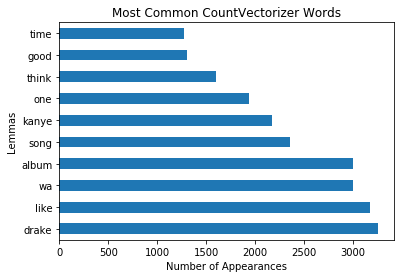

In [89]:
#creating graph for cvec most common words
cvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Most Common CountVectorizer Words')
plt.xlabel('Number of Appearances')
plt.ylabel('Lemmas');

## Using TfidfVectorizer
[Modeling](#Modeling)
1. [Random Forest](#Random-Forest-Model-(Tfidf))
2. [SVC](#SVC-Model-(Tfidf))
3. [AdaBoost](#AdaBoost-Model-(Tfidf))
4. [Naive Bayes](#Naive-Bayes-Model-(Tfidf))

### Random Forest Model (Tfidf)
[Modeling](#Modeling)

In [68]:
#pipeline for random forest with tfidf
rf_pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words=stopwords.words('english'),max_features=2000)),
    ('rf',RandomForestClassifier())
])
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier())])

In [69]:
#cv score for train data
cross_val_score(rf_pipe,X_train,y_train,cv=5).mean()

0.7179269050536009

In [70]:
#cv score for test data
cross_val_score(rf_pipe,X_test,y_test,cv=5).mean()

0.6929799088698443

### SVC Model (Tfidf)
[Modeling](#Using-TfidfVectorizer)

In [71]:
#pipeline for svc model with tfidf preprocessing
svc_pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('svc',SVC())
])
svc_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', SVC())])

In [72]:
#cv score for train data
cross_val_score(svc_pipe,X_train,y_train,cv=5).mean()

0.7128030255227262

In [73]:
#cv score for test data
cross_val_score(svc_pipe,X_test,y_test,cv=5).mean()

0.6966482320907208

### AdaBoost Model (Tfidf)
[Modeling](#Using-TfidfVectorizer)

In [74]:
#pipeline with minimal hyperparams for AdaBoost model with tfidf preprocessing
pipe_boost_tf = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('ada',AdaBoostClassifier())
])
pipe_boost_tf.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('ada', AdaBoostClassifier())])

In [75]:
#cv for train data
cross_val_score(pipe_boost_tf,X_train,y_train,cv=5).mean()

0.651317394433814

In [76]:
#cv for test data
cross_val_score(pipe_boost_tf,X_train,y_train,cv=5).mean()

0.651317394433814

### Naive Bayes Model (Tfidf)
[Modeling](#Using-TfidfVectorizer)

In [77]:
#pipeline for naive bayes model with minimal hyperparams
nb_pipe2 = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words=stopwords.words('english'),max_features=1000)),
    ('nb',MultinomialNB())
])
nb_pipe2.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [78]:
#cv score for train data
cross_val_score(nb_pipe2,X_train,y_train,cv=5).mean()

0.7023238341862761

In [79]:
#cv score for test data
cross_val_score(nb_pipe2,X_test,y_test,cv=5).mean()

0.6971443130218539